In [1]:
#modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
#constantes:
ri = 6e-3 #rayon interne du tube métallique en m
S=np.pi*ri**2
Rpropre = 5e-4 #résistance thermique du tube métallique m^2*K/W
E = 40e3 #énergie d'activation J/mol
R = 8.314 #constante des gaz parfaits en J/mol/K
Lambda_bio = 0.6 #conductivité thermique du biofilm W/m/K
Text = 35 + 273 #température de la fine couche d'eau sur la surface du tuyau en Kelvin (K)
Tin = 17 + 273 #température en entrée de l'eau dans le tuyau en Kelvin (K)
Dv = 1.85*S#débit volumique de de l'écoulement de Nabo m^3/s
rho = 1e3 #masse volumique de l'eau kg/m^3
Dm = rho*Dv #dénit massique de l'écoulement en Kg/s
cp = 4184 #capacité calorifique massique de l'eau J/Kg/K
temps_total_simulation = 60*24*3600 #de 60 jours
pi = np.pi
L = 3.1 #longueur totale du tuyau en m
dz = L/1000 #le pas d'espace en m
dt = 3600 #pas de temps en s
ei = 1e-6 #valeur initiale de l'épaisseur du biofilm de Nabo en m

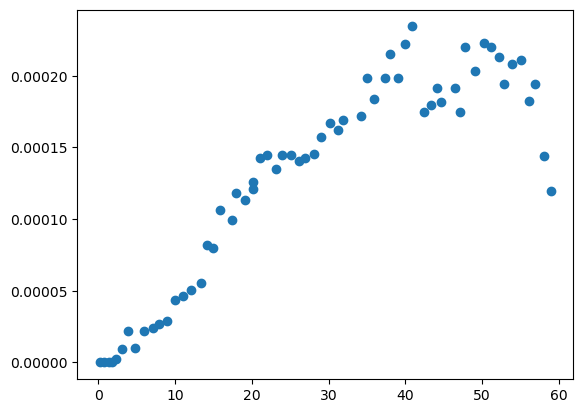

In [3]:
fichier = pd.read_excel("temps_nabo.xlsx")
fichier.head()
Donnees = fichier["Time,Resistance"]
tempsNabo, RNabo = [], []

for val in Donnees:
    val = str(val).split(',')
    tempsNabo.append(float(val[0]))
    RNabo.append(float(val[1]))

tempsNabo = np.array(tempsNabo)
RNabo = np.array(RNabo)*1e-3

eNabo = RNabo*Lambda_bio

plt.scatter(tempsNabo, eNabo)



In [4]:
k25 = 0.97e-2 #constante cinétique de vitesse en W/m^2/K/s
Rinf = 0.346e-3  #resistance thermique final du biofilm obtenu par les données de Nabo

einf = Rinf*Lambda_bio #valeur de l'épaisseur finale obtenue par Nabo
print(einf)

0.0002076


In [5]:
def de(T,e):
    result=(k25/Lambda_bio) * np.exp( - (E/R) * ( 1/T - 1/298.5 ) )*(einf-e)*e
    return(result)

def dT(T,e):
    result=( 1/(Dm*cp) ) * ( Text - T ) * 2*np.pi*ri / ( (e/Lambda_bio) + Rpropre )
    return(result)

In [6]:
#oileur

temps=np.arange(0,temps_total_simulation,dt)
Nt=len(temps)

Z=np.arange(0,L,dz)
Nz=len(Z)


def oiler(k,ei,E):
    
    E=E
    k25=k
    
    def de(T,e):
        result=(k25/Lambda_bio) * np.exp( - (E/R) * ( 1/T - 1/298.5 ) )*(einf-e)*e
        return(result)

    def dT(T,e):
        result=( 1/(Dm*cp) ) * ( Text - T ) * 2*np.pi*ri / ( (e/Lambda_bio) + Rpropre )
        return(result)

    temps=np.arange(0,temps_total_simulation,dt)
    Nt=len(temps)

    Z=np.arange(0,L,dz)
    Nz=len(Z)

    e=np.zeros((Nt,Nz))
    T=np.zeros((Nt,Nz))

    T[::,0]=Tin
    e[0,::]=ei

    #résolution oiler:
    for z in range(1,Nz):
        T[0,z]=T[0,z-1]+dz*dT(T[0,z-1],e[0,z-1])

    for t in range(1,Nt):
        for z in range(1,Nz):
            T[t,z]=T[t,z-1]+dz*dT(T[t,z-1],e[t,z-1])
            e[t,z]=e[t-1,z]+dt*de(T[t-1,z],e[t-1,z])

    return(T,e)
        





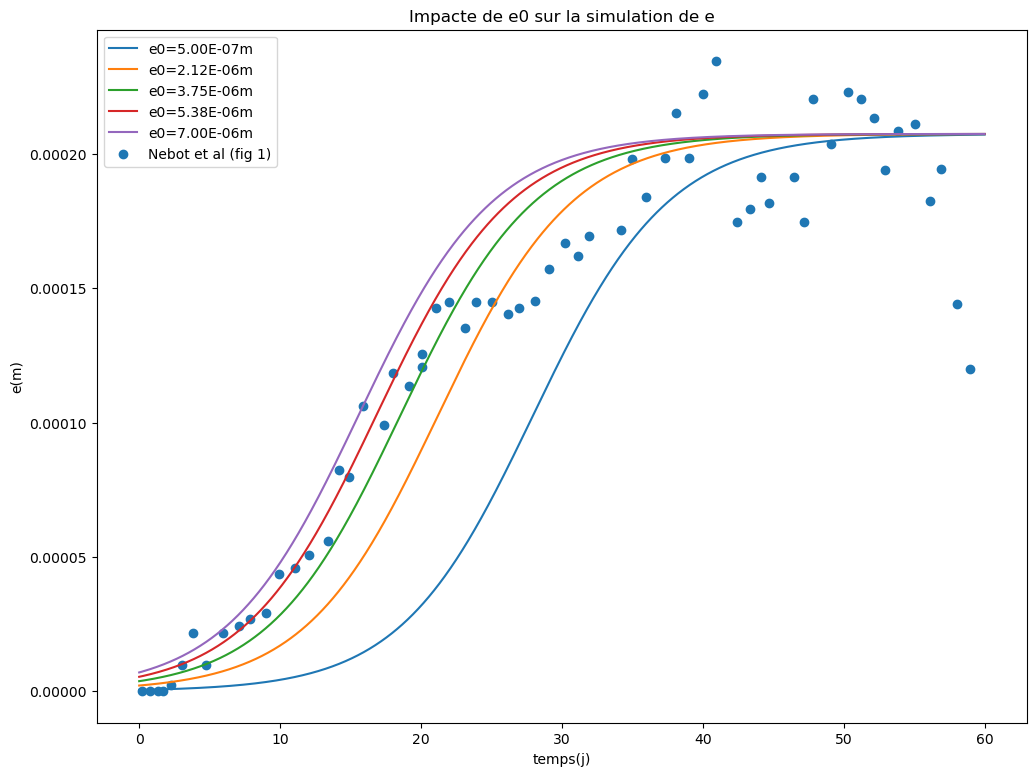

In [7]:
E=25e3
k25=0.9e-2
Ei=np.linspace(5e-7,7e-6,5)
plt.figure(figsize=(12,9))
for ei in Ei:
    T,e=oiler(k25,ei,E)
    eMean = e.mean(axis=1)
    plt.plot(temps/(24*3600),eMean,label="e0="+str(format(ei,'.2E'))+'m')
plt.scatter(tempsNabo,eNabo,label='Nebot et al (fig 1)')
plt.xlabel('temps(j)')
plt.ylabel('e(m)')
plt.title('Impacte de e0 sur la simulation de e')
plt.legend()
plt.show()

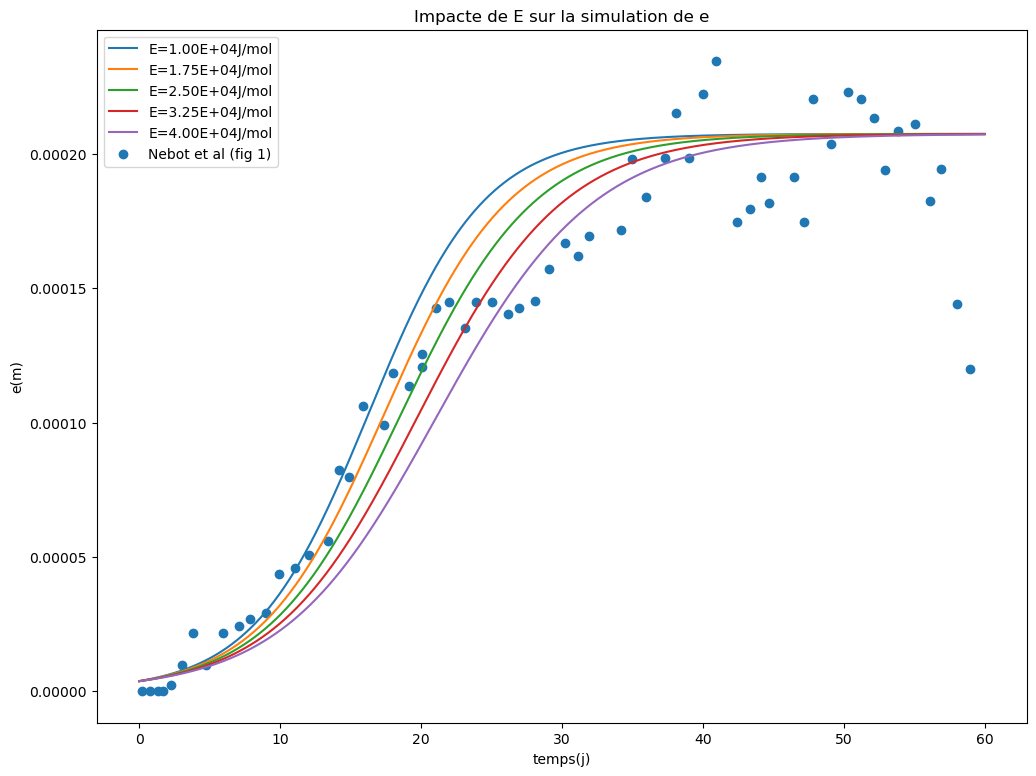

In [8]:
ei=3.75e-6
k25=0.9e-2
Ea=np.linspace(10e3,40e3,5)
plt.figure(figsize=(12,9))
for E in Ea:
    T,e=oiler(k25,ei,E)
    eMean = e.mean(axis=1)
    plt.plot(temps/(24*3600),eMean,label="E="+str(format(E,'.2E'))+'J/mol')
plt.scatter(tempsNabo,eNabo,label='Nebot et al (fig 1)')
plt.xlabel('temps(j)')
plt.ylabel('e(m)')
plt.title('Impacte de E sur la simulation de e')
plt.legend()
plt.show()

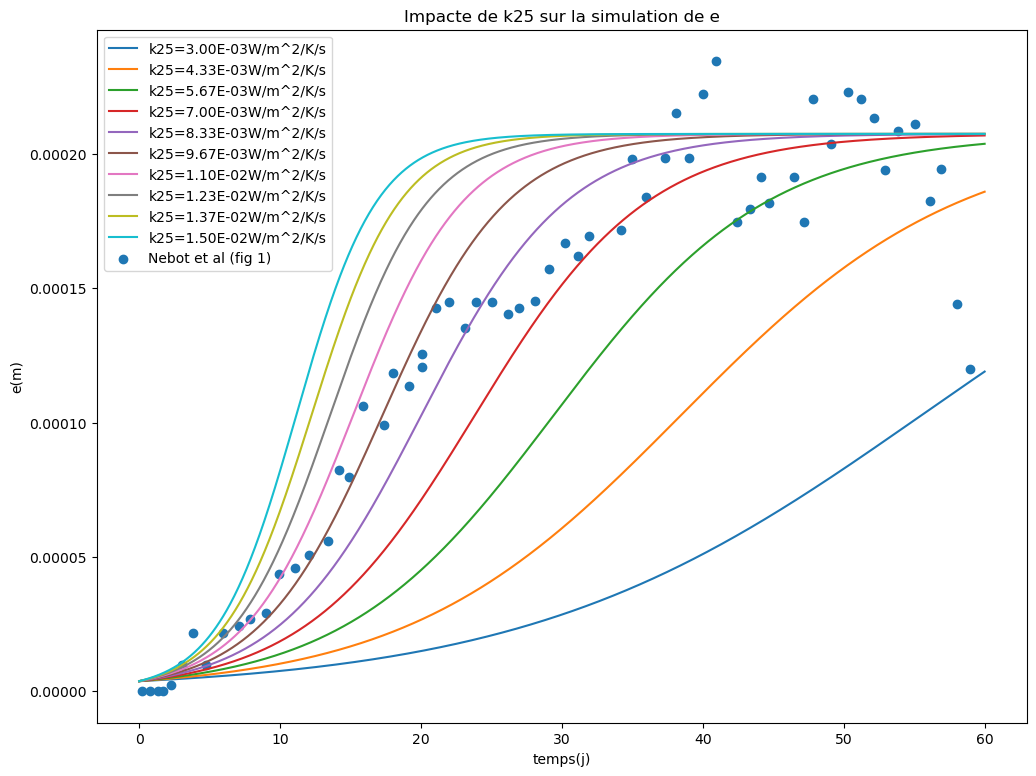

In [9]:
ei=3.75e-6
E=25e3
K25=np.linspace(0.3e-2,1.5e-2,10)
plt.figure(figsize=(12,9))
for k in K25:
    T,e=oiler(k,ei,E)
    eMean = e.mean(axis=1)
    plt.plot(temps/(24*3600),eMean,label="k25="+str(format(k, ".2E"))+'W/m^2/K/s')
plt.scatter(tempsNabo,eNabo,label='Nebot et al (fig 1)')
plt.legend()
plt.xlabel('temps(j)')
plt.ylabel('e(m)')
plt.title('Impacte de k25 sur la simulation de e')
plt.show()
k25=0.00967

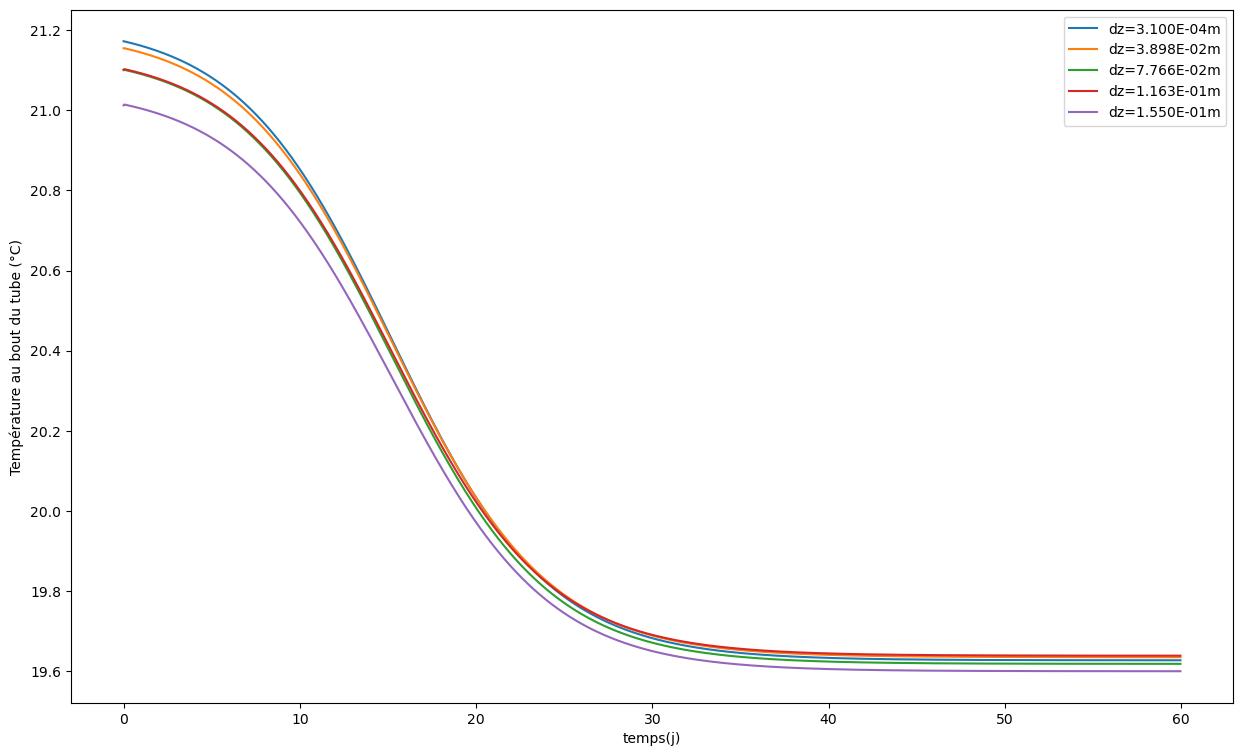

In [10]:
dt = 3600 #pas de temps en s
ei=3.75e-6
E=25e3
k25=0.00967
def oiler2(dz):
    
    def de(T,e):
        result=(k25/Lambda_bio) * np.exp( - (E/R) * ( 1/T - 1/298.5 ) )*(einf-e)*e
        return(result)

    def dT(T,e):
        result=( 1/(Dm*cp) ) * ( Text - T ) * 2*np.pi*ri / ( (e/Lambda_bio) + Rpropre )
        return(result)

    temps=np.arange(0,temps_total_simulation,dt)
    Nt=len(temps)

    Z=np.arange(0,L,dz)
    Nz=len(Z)

    e=np.zeros((Nt,Nz))
    T=np.zeros((Nt,Nz))

    T[::,0]=Tin
    e[0,::]=ei

    #résolution oiler:
    for z in range(1,Nz):
        T[0,z]=T[0,z-1]+dz*dT(T[0,z-1],e[0,z-1])

    for t in range(1,Nt):
        for z in range(1,Nz):
            T[t,z]=T[t,z-1]+dz*dT(T[t,z-1],e[t,z-1])
            e[t,z]=e[t-1,z]+dt*de(T[t-1,z],e[t-1,z])

    return(T,e)


list_dz=np.linspace(L/10000,L/20,5)
plt.figure(figsize=(15,9))
for dz in list_dz:
    temps=np.arange(0,temps_total_simulation,dt)
    Nt=len(temps)
    Z=np.arange(0,L,dz)
    Nz=len(Z)
    T,e=oiler2(dz)
    Temp=T[::,-1]
    plt.plot(temps/(24*3600),Temp-273,label='dz='+str(format(dz,'.3E'))+'m')
plt.xlabel('temps(j)')
plt.ylabel('Température au bout du tube (°C)')
plt.legend()
plt.show()

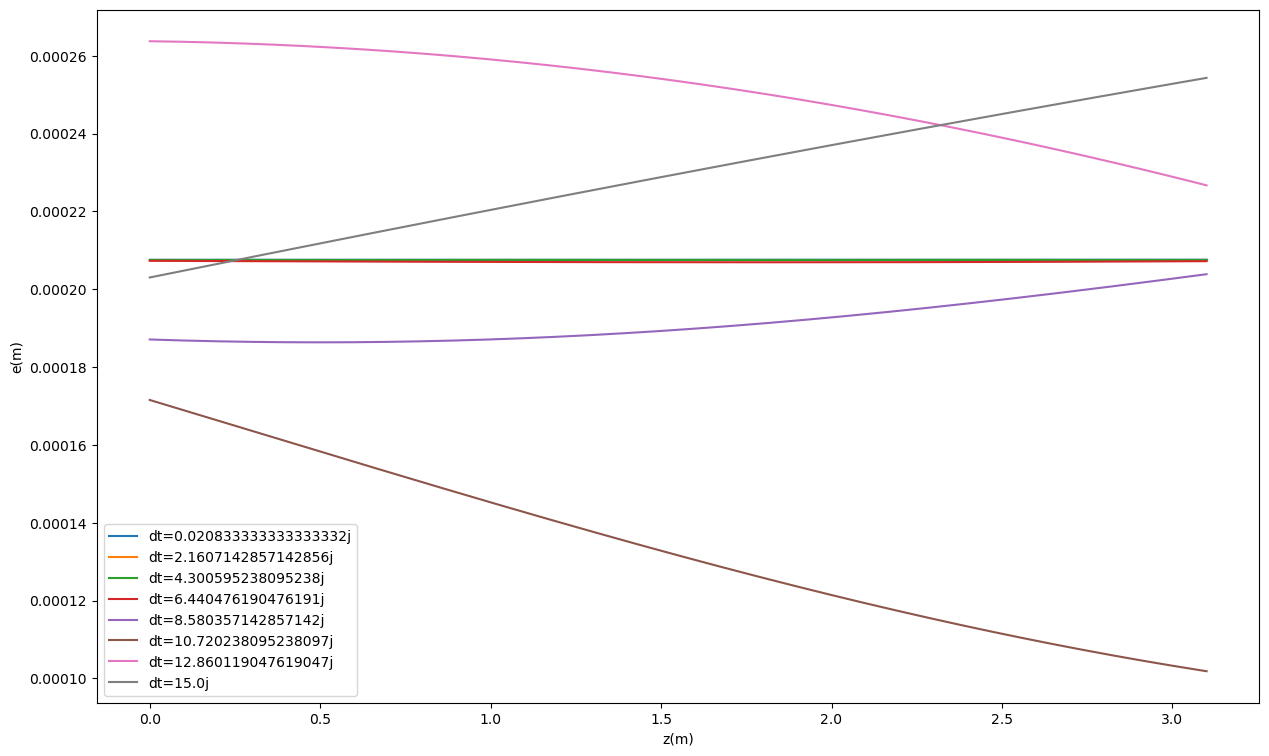

In [11]:
ei=3.75e-6
E=25e3
k25=0.00967
dz = L/1000 #le pas d'espace en m

def oiler3(dt):
    
    def de(T,e):
        result=(k25/Lambda_bio) * np.exp( - (E/R) * ( 1/T - 1/298.5 ) )*(einf-e)*e
        return(result)

    def dT(T,e):
        result=( 1/(Dm*cp) ) * ( Text - T ) * 2*np.pi*ri / ( (e/Lambda_bio) + Rpropre )
        return(result)

    temps=np.arange(0,temps_total_simulation,dt)
    Nt=len(temps)

    Z=np.arange(0,L,dz)
    Nz=len(Z)

    e=np.zeros((Nt,Nz))
    T=np.zeros((Nt,Nz))

    T[::,0]=Tin
    e[0,::]=ei

    #résolution oiler:
    for z in range(1,Nz):
        T[0,z]=T[0,z-1]+dz*dT(T[0,z-1],e[0,z-1])
    for t in range(1,Nt):
        e[t,0]=e[t-1,0]+dt*de(T[t-1,0],e[t-1,0])
    for t in range(1,Nt):
        for z in range(1,Nz):
            T[t,z]=T[t,z-1]+dz*dT(T[t,z-1],e[t,z-1])
            e[t,z]=e[t-1,z]+dt*de(T[t-1,z],e[t-1,z])

    return(T,e)


list_dt=np.linspace(3600//2,15*3600*24,8)

plt.figure(figsize=(15,9))

for dt in list_dt:
    temps=np.arange(0,temps_total_simulation,dt)
    Nt=len(temps)
    Z=np.arange(0,L,dz)
    Nz=len(Z)

    T,e=oiler3(dt)

    epai=e[-1,::]

    plt.plot( Z , epai ,label='dt='+str(dt/(3600*24))+"j")

plt.xlabel('z(m)')
plt.ylabel('e(m)')
plt.legend()
plt.show()

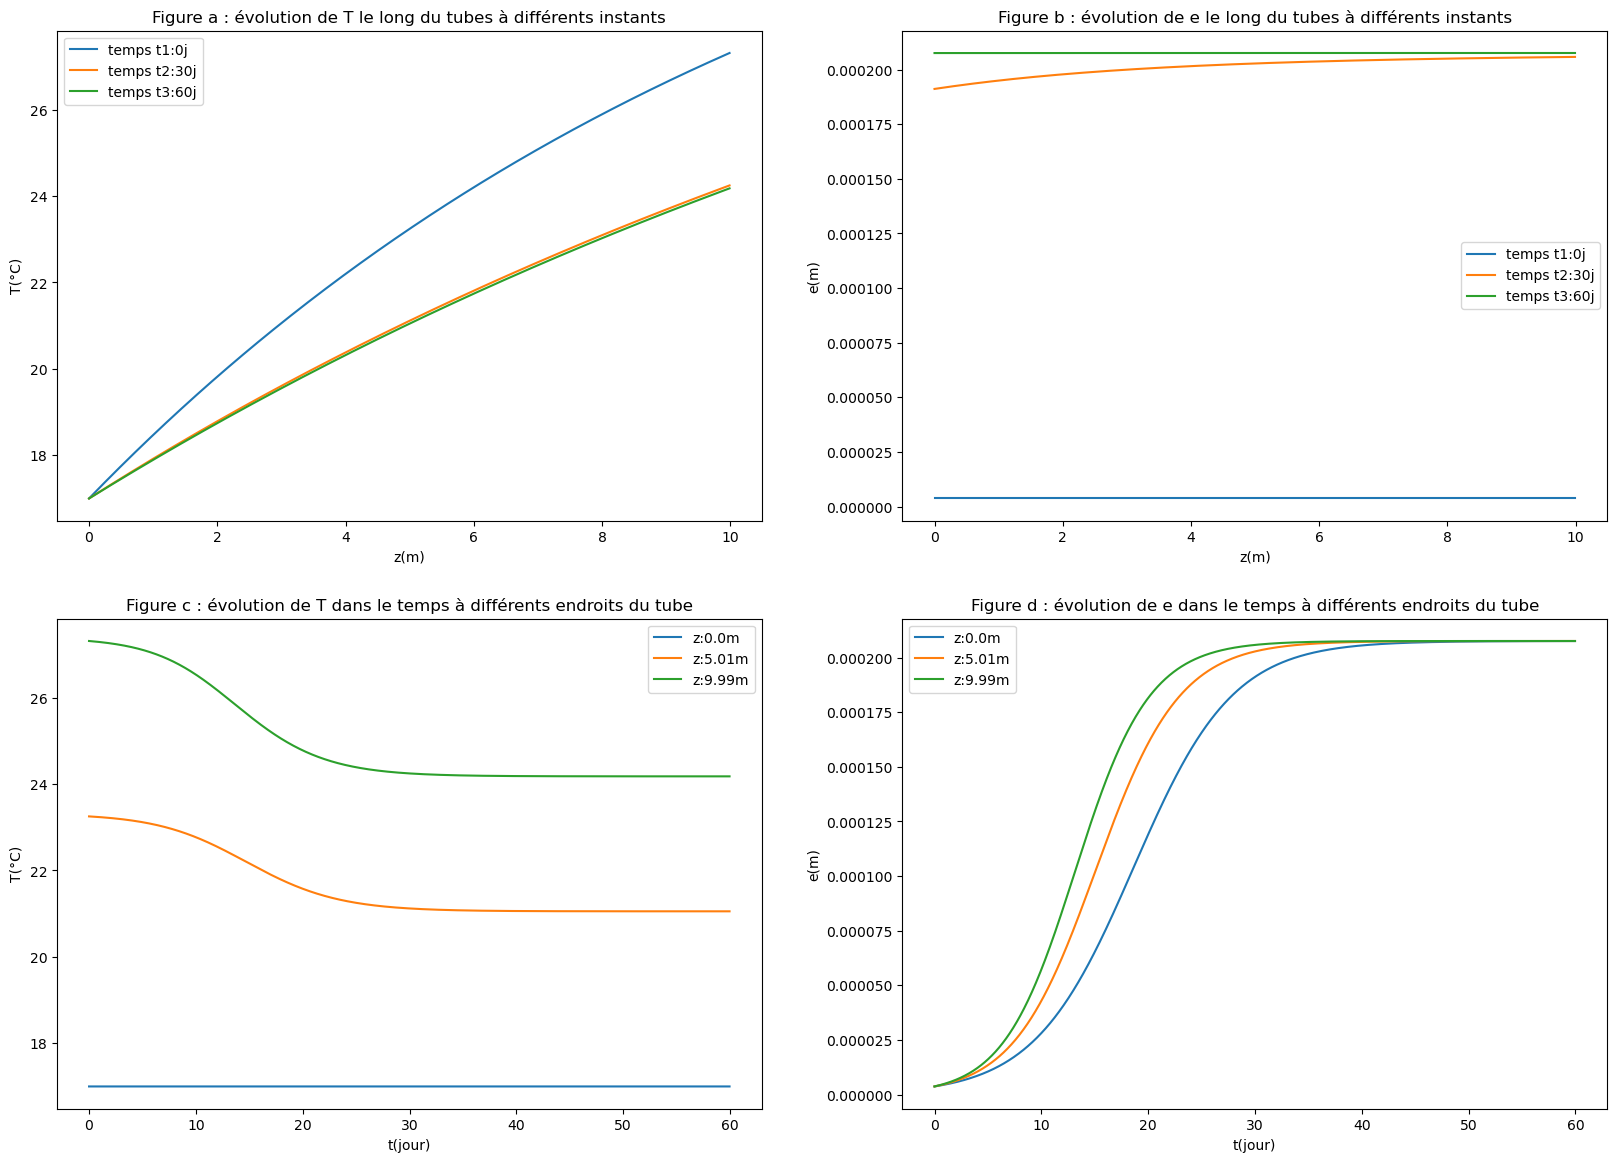

In [12]:


e0=3.75e-6
E=25e3
k25=0.00967
L=10
dz = 3e-2 #le pas d'espace en m
dt = 3600 #pas de temps en s

temps=np.arange(0,temps_total_simulation,dt)
Nt=len(temps)
Z=np.arange(0,L,dz)
Nz=len(Z)

def oiler():
    
    def de(T,e):
        result=(k25/Lambda_bio) * np.exp( - (E/R) * ( 1/T - 1/298.5 ) )*(einf-e)*e
        return(result)

    def dT(T,e):
        result=( 1/(Dm*cp) ) * ( Text - T ) * 2*np.pi*ri / ( (e/Lambda_bio) + Rpropre )
        return(result)


    temps=np.arange(0,temps_total_simulation,dt)
    Nt=len(temps)

    Z=np.arange(0,L,dz)
    Nz=len(Z)

    e=np.zeros((Nt,Nz))
    T=np.zeros((Nt,Nz))


    T[::,0]=Tin
    e[0,::]=e0
    

    #résolution oiler:
    for z in range(1,Nz):
        T[0,z]=T[0,z-1]+dz*dT(T[0,z-1],e[0,z-1])
    for t in range(1,Nt):
        e[t,0]=e[t-1,0]+dt*de(T[t-1,0],e[t-1,0])

    for t in range(1,Nt):
        for z in range(1,Nz):
            T[t,z]=T[t,z-1]+dz*dT(T[t,z-1],e[t,z-1])
            e[t,z]=e[t-1,z]+dt*de(T[t-1,z],e[t-1,z])

    return(T,e)
    
T,e=oiler()

t1, t2, t3 = 0, Nt//2, -1
z1, z2, z3 = 0, Nz//2, -1
tempsJour = temps/(3600*24)
TC = T - 273
plt.figure(figsize=(20,14))

plt.subplot(2,2,1)
plt.plot(Z, TC[t1,::], label=f"temps t1:{round(tempsJour[t1])}j")
plt.plot(Z, TC[t2,::], label=f"temps t2:{round(tempsJour[t2])}j")
plt.plot(Z, TC[t3,::], label=f"temps t3:{round(tempsJour[t3])}j")
plt.xlabel("z(m)")
plt.ylabel("T(°C)")
plt.title('Figure a : évolution de T le long du tubes à différents instants')
plt.legend()

plt.subplot(2,2,2)
plt.plot(Z, e[t1,::], label=f"temps t1:{round(tempsJour[t1])}j")
plt.plot(Z, e[t2,::], label=f"temps t2:{round(tempsJour[t2])}j")
plt.plot(Z, e[t3,::], label=f"temps t3:{round(tempsJour[t3])}j")
plt.xlabel("z(m)")
plt.ylabel("e(m)")
plt.title('Figure b : évolution de e le long du tubes à différents instants')
plt.legend()

plt.subplot(2,2,3)
plt.plot(tempsJour, TC[::, z1], label=f"z:{Z[z1]}m")
plt.plot(tempsJour, TC[::, z2], label=f"z:{Z[z2]}m")
plt.plot(tempsJour, TC[::, z3], label=f"z:{Z[z3]}m")
plt.xlabel("t(jour)")
plt.ylabel("T(°C)")
plt.title('Figure c : évolution de T dans le temps à différents endroits du tube')
plt.legend()

plt.subplot(2,2,4)
plt.plot(tempsJour, e[::, z1], label=f"z:{Z[z1]}m")
plt.plot(tempsJour, e[::, z2], label=f"z:{Z[z2]}m")
plt.plot(tempsJour, e[::, z3], label=f"z:{Z[z3]}m")
#plt.scatter(tempsNabo,eNabo, label='Nebolt')
#eMean = e.mean(axis=1)
#plt.plot(temps/(24*3600),eMean,label="courbe réglée")
plt.xlabel("t(jour)")
plt.ylabel("e(m)")
plt.title('Figure d : évolution de e dans le temps à différents endroits du tube')
plt.legend()